# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 3</span>



In this exercise we simulate the evolution of a financial market under the Black–Scholes framework, where the asset price follows a geometric Brownian motion. Using Monte Carlo methods, we estimate the fair price of European call and put options, comparing both a direct evaluation at $T$ and a discretized time evolution, showing their equivalence.


# Financial Market and Black–Scholes Model

A financial market is defined as the place where agents exchange assets, with the spot price $S(t)$ determined by supply and demand.  
The **Efficient Market Hypothesis (EMH)** assumes that all relevant information is immediately reflected in the price, that markets are liquid, and that transaction costs (frictions) are negligible. Under EMH, the future evolution of the price depends only on its current value, following a Markov property.

- **Liquidity:** a market is liquid if any investor can easily buy or sell a financial product at any time. High liquidity ensures that assets can always be converted into cash quickly and at prices close to their fair value, which increases the attractiveness and safety of investments.

- **Low market frictions:** market frictions represent all kinds of trading costs (transaction fees, bid–ask spreads, taxes, delays, etc.). If these costs are negligible compared to the transaction volume, the market is considered frictionless.

---

## European Options

A **European option** is a financial contract defined on an underlying asset with spot price $S(t)$.  
At maturity $T$, the contract specifies a **strike price** $K$ and establishes two distinct roles:

- **Holder (buyer of the option):** pays a premium at time $t=0$ and acquires a right, but not the obligation.  
- **Writer (seller of the option):** receives the premium and assumes the obligation to fulfill the contract if the holder exercises it.

Two main types of European options exist:

- **Call option:** the holder has the right to *buy* the asset from the writer at price $K$ at time $T$.  
  - Payoff:  
    $$ \pi_{\text{call}} = \max(0, S(T) - K) $$

- **Put option:** the holder has the right to *sell* the asset to the writer at price $K$ at time $T$.  
  - Payoff:  
    $$ \pi_{\text{put}} = \max(0, K - S(T)) $$

Key point:  
- The **holder** can only gain from exercising the option; the maximum loss is limited to the premium initially paid.  
- The **writer** earns the premium upfront but may incur significant losses depending on the future market movement.

---

## Black–Scholes Market Assumptions

The Black–Scholes theory for option pricing is based on two key assumptions:

1. **Maximally efficient market:** the market is infinitely liquid and exhibits no frictions.  
2. **Stochastic asset dynamics:** the asset price follows a geometric Brownian motion with constant risk–free rate $r$ and constant volatility $\sigma$.

Formally, the asset price evolves according to geometric brownian motion

$$ dS(t) = r S(t) dt + \sigma S(t) dW(t) $$

where $r$ is the risk–free interest rate, $\sigma$ the volatility, and $W(t)$ a Wiener process.

The Black–Scholes theory then provides closed–form solutions for the fair prices of European call and put options at time $t<T$:

- Call price:
  $$ C(S(t),t) = S(t) N(d_1) - K e^{-r(T-t)} N(d_2) $$

- Put price:
  $$ P(S(t),t) = K e^{-r(T-t)} N(-d_2) - S(t) N(-d_1) $$

where

$$ d_1 = \frac{\ln \frac{S(t)}{K} + (r + \tfrac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T-t}}, \quad d_2 = d_1 - \sigma \sqrt{T-t} $$

and $N(x)$ is the cumulative distribution function of a standard Gaussian:

$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$

and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}. $$


We now compute the analytical prices of European call and put options according to the Black–Scholes formula, to use them as a reference for our numerical simulations

In [41]:
import scipy
from scipy.special import erf
import numpy as np
from numpy import exp
from numpy.lib.scimath import log, sqrt

# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", call)
    print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


# Monte Carlo Simulation of Option Prices

To estimate the option prices numerically, we simulate the stochastic evolution of the asset price $S(t)$ using the Monte Carlo method.  

- **Direct approach (single step $0 \to T$):**  
  We generate $N$ independent realizations of the terminal price $S(T)$ according to

  $$ S(T) = S(0) \exp \Big[ (r - \tfrac{1}{2}\sigma^2) T + \sigma Z \sqrt{T} \Big] $$

  with $Z \sim \mathcal{N}(0,1)$.  

- **Discretized approach:**  
  We divide the interval $[0,T]$ into $M$ steps and evolve the price iteratively:

  $$ S(t_{i+1}) = S(t_i) \exp \Big[ (r - \tfrac{1}{2}\sigma^2) \Delta t + \sigma Z_i \sqrt{\Delta t} \Big], \quad \Delta t = \tfrac{T}{M} $$

  Both approaches yield equivalent results for sufficiently large $N$.

- **Option valuation:**  
  For each simulated trajectory, we compute the discounted payoff:

  - Call: $$ C_i = e^{-rT} \max(0, S_i(T) - K) $$
  - Put: $$ P_i = e^{-rT} \max(0, K - S_i(T)) $$

  The option price is then estimated as the statistical average:

  $$ C \approx \frac{1}{N} \sum_{i=1}^N C_i, \quad P \approx \frac{1}{N} \sum_{i=1}^N P_i $$



## Statistical Uncertainty: Data Blocking

To evaluate the statistical error on the Monte Carlo estimates, we applied the **data blocking method**.  
In practice, the $100\,000$ simulated stochastic trajectories were divided into $100$ blocks.  
For each block we computed the average option price, and then used the variance of the block averages to estimate the statistical uncertainty.  
This approach ensures a reliable error analysis by reducing correlations between data and providing the standard deviation of the mean as the final uncertainty.


In [42]:
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd

In [43]:
data_call=pd.read_csv("output_call.txt", sep="\t")
data_call=data_call.drop('Unnamed: 4',axis=1)
data_put=pd.read_csv("output_put.txt", sep="\t")
data_put=data_put.drop('Unnamed: 4',axis=1)



In [44]:
def plot_options(data, option_type="CALL", analytic_value=0.0):
    """
    Plot the estimated option price (call or put) as a function of the number of processes,
    comparing direct and indirect sampling. The analytical Black–Scholes price is always shown.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing results with columns:
        '<option_type>_dir', 'Err_<option_type>_dir',
        '<option_type>_ind', 'Err_<option_type>_ind'
    option_type : str
        "CALL" or "PUT" (default = "CALL")
    analytic_value : float
        Analytical Black–Scholes price of the option (must be provided).
    """
    
    M = 100000
    N = 100
    L = M // N
    x = np.arange(N)  
    x = x * L
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Direct sampling
    axes[0].errorbar(
        x, data[f"{option_type}_dir"], 
        yerr=data[f"Err_{option_type}_dir"], 
        ecolor='red',
        label='Monte Carlo'
    )
    axes[0].axhline(analytic_value, color='green', linestyle='--', label='Analytical')
    axes[0].set_title('Direct sampling')
    axes[0].set_xlabel('#GBM')
    axes[0].set_ylabel(fr'$<{option_type.title()}>$')
    axes[0].grid(True)
    axes[0].legend()
    
    # Indirect sampling
    axes[1].errorbar(
        x, data[f"{option_type}_ind"], 
        yerr=data[f"Err_{option_type}_ind"], 
        ecolor='red',
        label='Monte Carlo'
    )
    axes[1].axhline(analytic_value, color='green', linestyle='--', label='Analytical')
    axes[1].set_title('Indirect sampling')
    axes[1].set_xlabel('#GBM')
    axes[1].set_ylabel(fr'$<{option_type.title()}>$')
    axes[1].grid(True)
    axes[1].legend()

    ymin = min(axes[0].get_ylim()[0], axes[1].get_ylim()[0])
    ymax = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
    axes[0].set_ylim(ymin, ymax)
    axes[1].set_ylim(ymin, ymax)
    
    plt.tight_layout()
    plt.show()


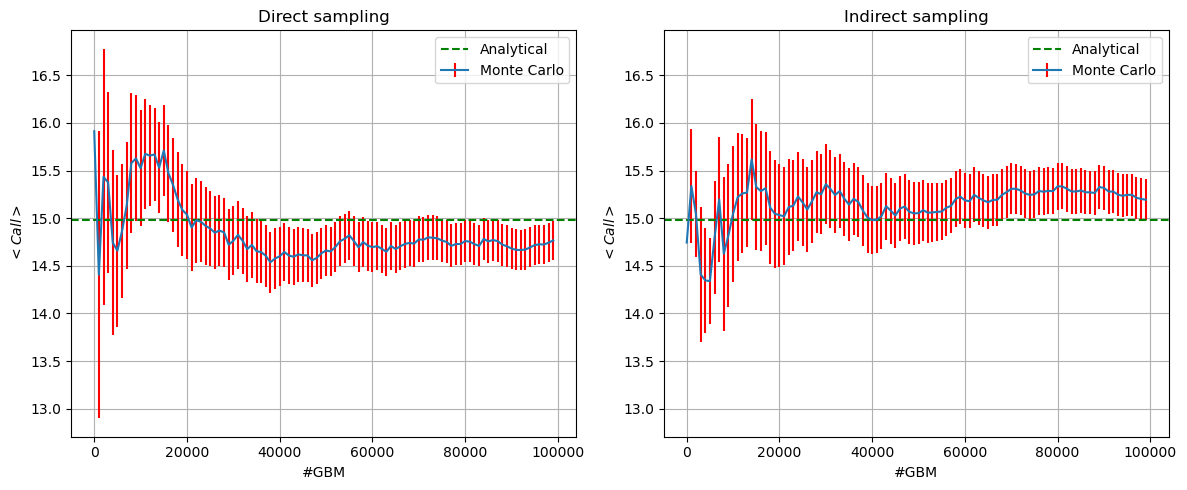

In [45]:
plot_options(data_call, option_type="CALL", analytic_value=call)


**Figure 1 – European Call option price.**  
Estimated call price as a function of the number of generated stochastic processes.  
Left: direct sampling.  
Right: indirect sampling.  
Blue markers with error bars represent the Monte Carlo estimates, while the green dashed line shows the analytical Black–Scholes solution.  
The simulated results converge to the analytic value within the expected statistical uncertainty.


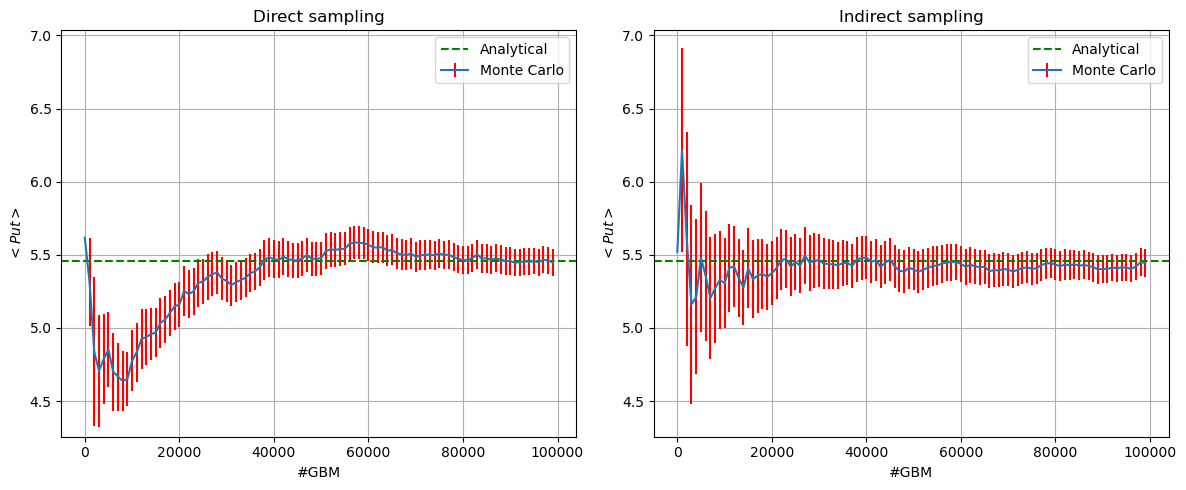

In [47]:
plot_options(data_put, option_type="PUT", analytic_value=put)

**Figure 2 – European Put option price.**  
Estimated put price as a function of the number of generated stochastic processes.  
Left: direct sampling.  
Right: indirect sampling.  
Blue markers with error bars correspond to Monte Carlo results, while the green dashed line indicates the analytical Black–Scholes price.  
Also in this case, the Monte Carlo estimates approach the theoretical result within one or two standard deviations.


# Conclusions

The numerical results obtained for both call and put European options demonstrate that the Monte Carlo simulation correctly reproduces the theoretical expectations of the Black–Scholes model.

The figures clearly show that both approaches – direct sampling and indirect sampling, produce results that are **statistically consistent** with the analytic Black–Scholes values. In particular:

- The estimates remain within **1–2 standard deviations ($\sigma$)** from the analytic solution, confirming the statistical correctness of the simulation.  
- As the number of generated stochastic processes increases, the estimates stabilize and the size of the error bars decreases, as expected from the central limit theorem.  
- The discretization of the time interval into substeps ($M=100$ in our case) does not introduce any bias: the results from indirect sampling coincide with those from direct sampling within the statistical uncertainty.  

In conclusion, the Monte Carlo approach provides reliable estimates of European option prices, and the comparison with the analytic Black–Scholes results validates both the implementation and the methodology used. The data blocking analysis further ensures that the reported uncertainties are robust and meaningful.
